✅ Data loaded — Shape: (518706, 95)
Target classes: [0 1]


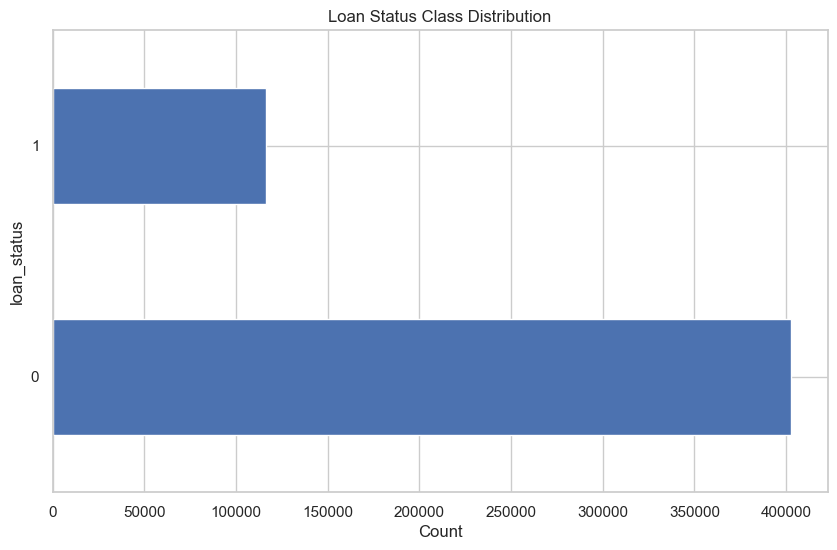

loan_status
0    0.776
1    0.224
Name: proportion, dtype: float64
✅ Winsorized 'dti' at 99th percentile = 42.93
✅ Winsorized 'annual_inc' at 99th percentile = 275,000


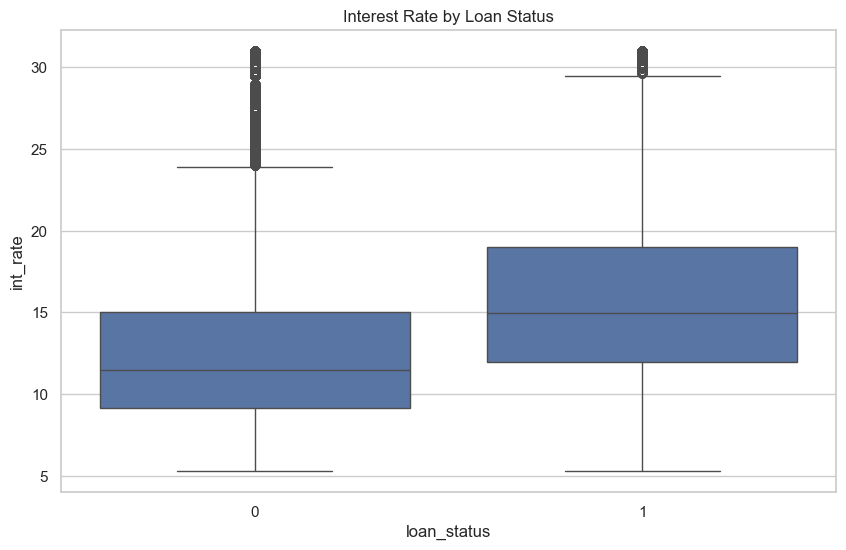

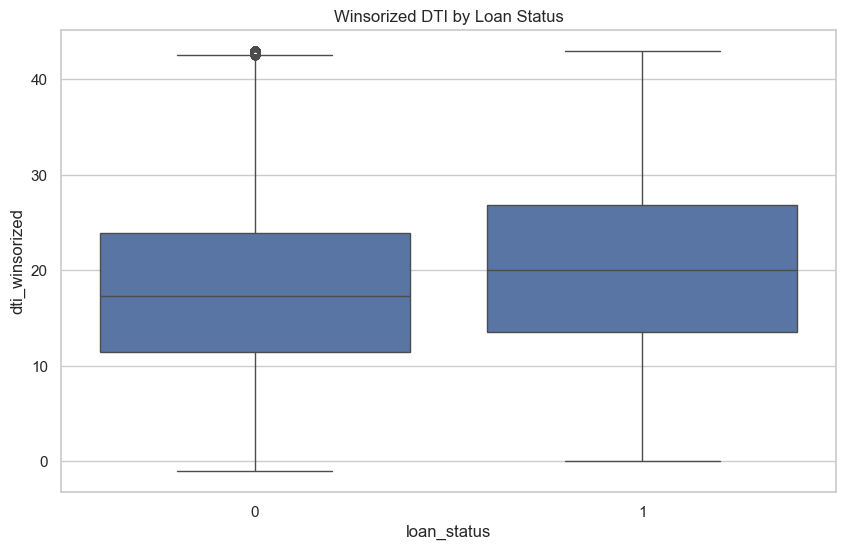

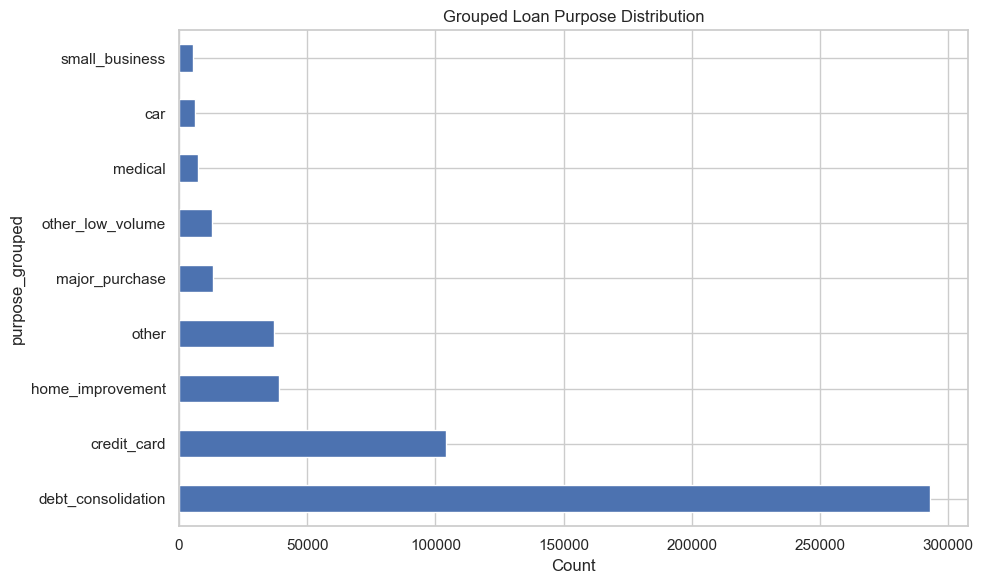

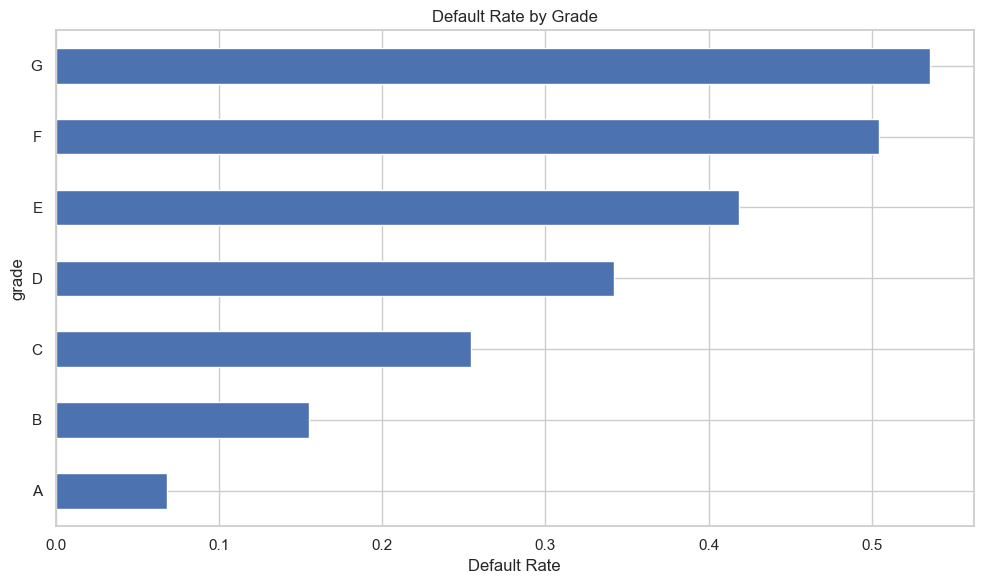

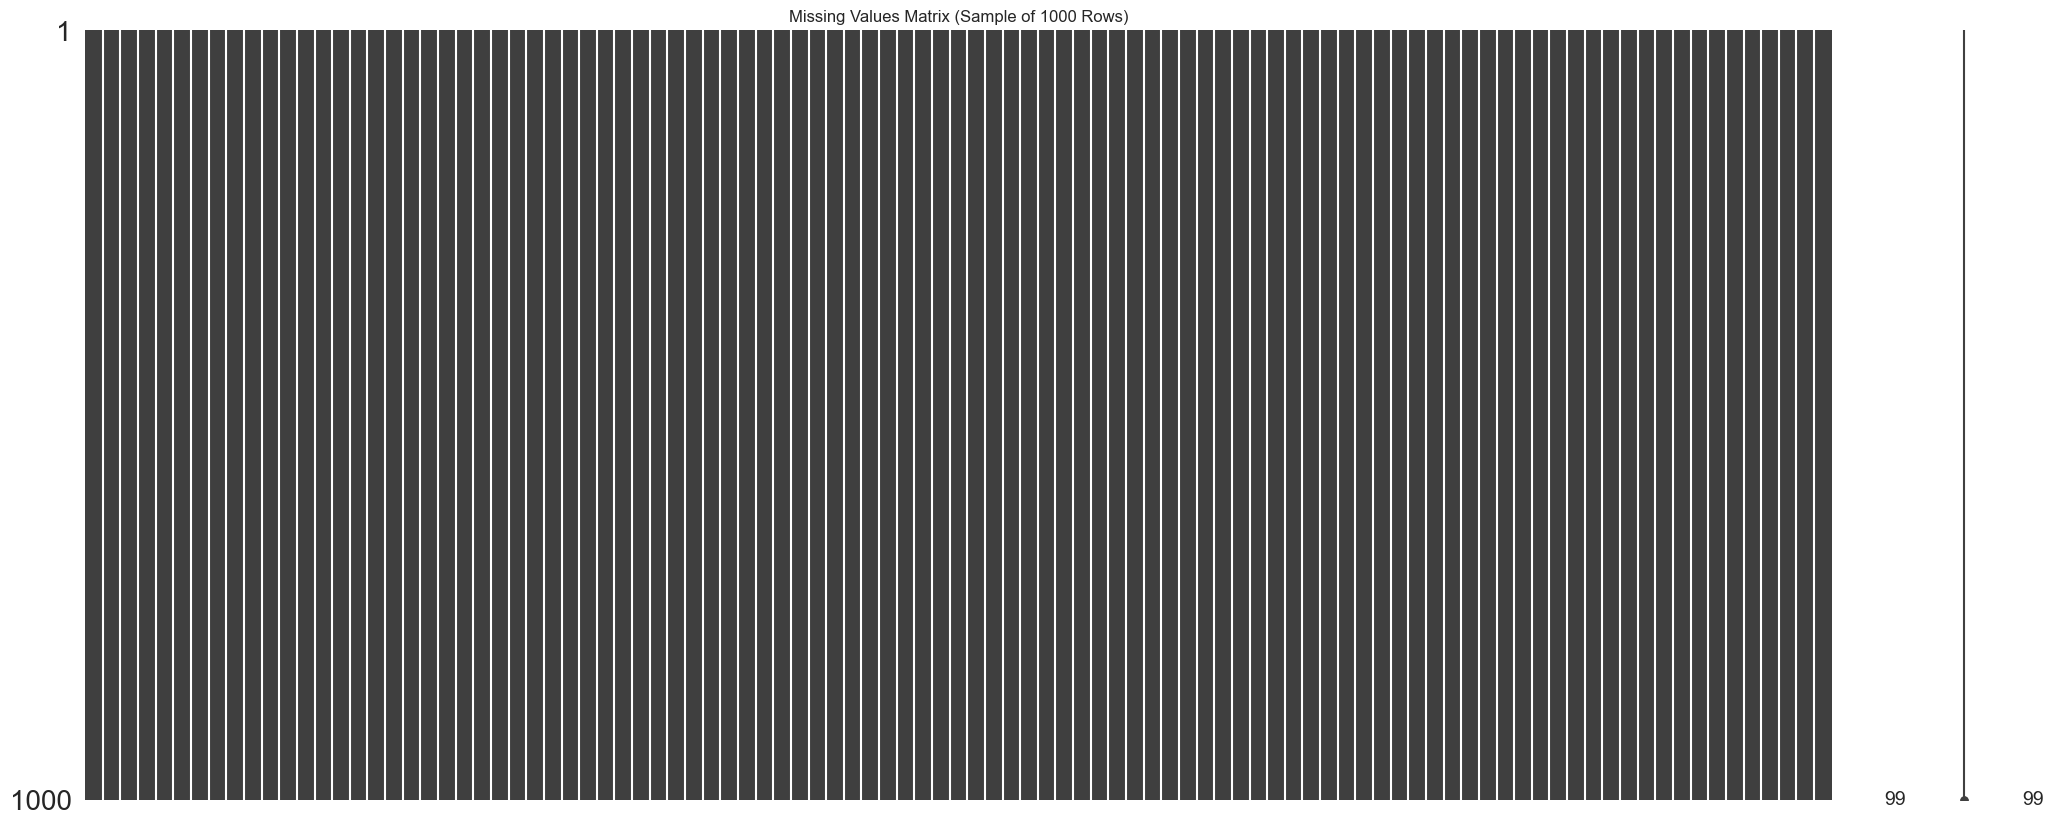

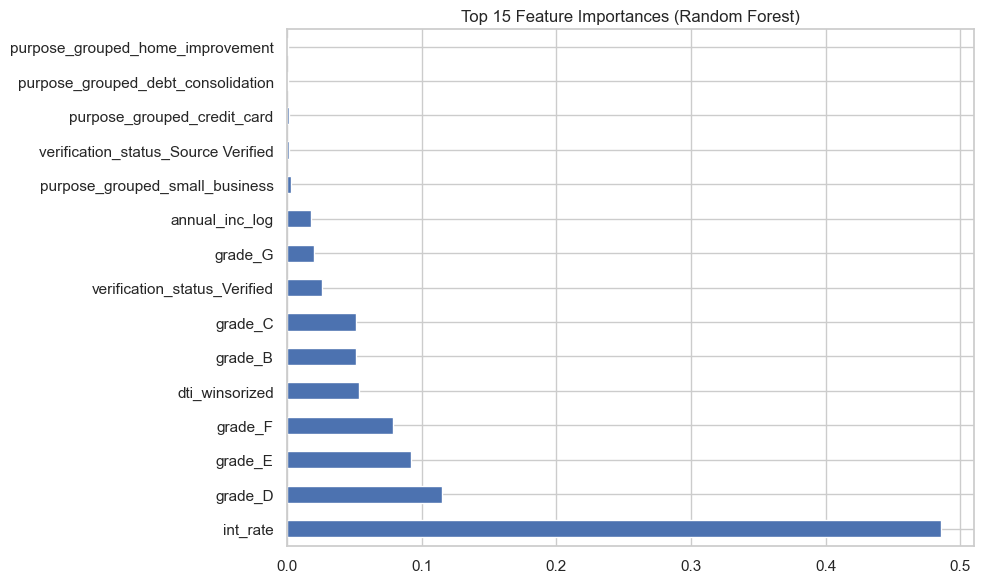

💾 Final model-ready dataset saved to: c:\Users\Alain\OneDrive\Desktop\Alain\Code Projects\borrowiq\data\processed\borrowiq_final_model_ready.csv


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import matplotlib.ticker as mtick
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# --- Config ---
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# --- Utility Functions ---
def winsorize_feature(df, col, quantile=0.99):
    cap = df[col].quantile(quantile)
    new_col = f"{col}_winsorized"
    df[new_col] = df[col].clip(upper=cap)
    return df, cap

def group_rare_categories(df, col, threshold=0.01):
    value_counts = df[col].value_counts()
    rare = value_counts[value_counts < threshold * len(df)].index
    new_col = f"{col}_grouped"
    df[new_col] = df[col].replace(rare, 'other_low_volume')
    return df

def plot_default_rate_by_categorical(df, col):
    rates = df.groupby(col)['loan_status'].mean().sort_values()
    rates.plot(kind='barh', title=f'Default Rate by {col.title()}')
    plt.xlabel('Default Rate')
    plt.tight_layout()
    plt.show()

# --- Paths ---
root_dir = Path.cwd().parents[0]
data_path = root_dir / "data" / "processed" / "borrowiq_cleaned.csv"
output_path = root_dir / "data" / "processed" / "borrowiq_final_model_ready.csv"

# --- Load Data ---
assert data_path.exists(), f"❌ File not found: {data_path}"
df = pd.read_csv(data_path)
print(f"✅ Data loaded — Shape: {df.shape}")

# --- Target Check ---
print("Target classes:", df['loan_status'].unique())
df['loan_status'].value_counts().plot(kind='barh', title='Loan Status Class Distribution')
plt.xlabel('Count')
plt.show()
print(df['loan_status'].value_counts(normalize=True).round(3))

# --- Feature Engineering ---
df, dti_cap = winsorize_feature(df, 'dti')
df, income_cap = winsorize_feature(df, 'annual_inc')
df['annual_inc_log'] = np.log1p(df['annual_inc_winsorized'])

print(f"✅ Winsorized 'dti' at 99th percentile = {dti_cap:.2f}")
print(f"✅ Winsorized 'annual_inc' at 99th percentile = {income_cap:,.0f}")

# --- Group Categorical ---
df = group_rare_categories(df, 'purpose')

# --- Visuals ---
sns.boxplot(data=df, x='loan_status', y='int_rate')
plt.title('Interest Rate by Loan Status')
plt.show()

sns.boxplot(data=df, x='loan_status', y='dti_winsorized')
plt.title('Winsorized DTI by Loan Status')
plt.show()

df['purpose_grouped'].value_counts().plot(kind='barh', title='Grouped Loan Purpose Distribution')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

plot_default_rate_by_categorical(df, 'grade')

# --- Missing Values ---
msno.matrix(df.sample(min(1000, len(df)), random_state=42))
plt.title("Missing Values Matrix (Sample of 1000 Rows)")
plt.show()

# --- Drop Leakage ---
leakage_cols = ['total_pymnt_inv', 'last_fico_range_high', 'last_fico_range_low']
df.drop(columns=[col for col in leakage_cols if col in df.columns], inplace=True)

# --- Interaction Features ---
if df['int_rate'].nunique() > 10:
    df['int_rate_bin'] = pd.qcut(df['int_rate'], q=3, labels=['low', 'medium', 'high'])
else:
    df['int_rate_bin'] = pd.cut(df['int_rate'], bins=[0, 10, 15, np.inf], labels=['low', 'medium', 'high'])

df['int_rate_bin'] = df['int_rate_bin'].astype(str)
df['int_rate_grade'] = df['grade'].astype(str) + '_' + df['int_rate_bin']

# --- Feature Importance Preview (Streamlined) ---
X = df[['int_rate', 'dti_winsorized', 'annual_inc_log', 'grade', 'purpose_grouped', 'verification_status']].copy()
X['grade'] = X['grade'].astype(str)
X = pd.get_dummies(X, drop_first=True)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
rf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.nlargest(15).plot(kind='barh')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

# --- Save Final Dataset ---
output_path.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(output_path, index=False)
print(f"💾 Final model-ready dataset saved to: {output_path}")
